In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import sys

sys.path.insert(0, "/Users/flynnwang/repo/flynn/eco_bang_bang/agents/rule_0202")

In [3]:
sys.path.insert(0, "/Users/flynnwang/repo/flynn/eco_bang_bang/agents")

In [4]:
# from ebb.env.const import *

In [5]:
import torch

from ecobangbang.env.luxenv import get_ob_sapce, LuxS3Env
from ecobangbang.model import _create_model, RewardSpec

reward_spec = RewardSpec(
        reward_min=-5,
        reward_max=+5,
        zero_sum=False,
    )

reward_shaping_params = dict(  new_observed_down_tri=0.0001,
  match_observed=0,
  match_win=1,
  use_hidden_relic_estimator=True,
  energy_cost_change=0.001,                             
)

obs_space_kwargs = {
    'use_energy_cost_map': True,
    'use_single_player': False,
}
env = LuxS3Env(reward_schema='match_explore_win_loss',
               reward_shaping_params=reward_shaping_params,
              obs_space_kwargs=obs_space_kwargs)

obs, reward, done, info = env.reset()

In [6]:
from ecobangbang.agent import Agent

from rule_v3_4a0760b.ecobangbang.agent import Agent as Agent2

# Feature Plots

In [7]:
def plot_imgs(images):
    grid_size = 3
    fig, axes = plt.subplots(grid_size + 1, grid_size, figsize=(10, 10))
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            name, img = images[i]
            img = img.T
            ax.imshow(img, cmap='viridis')  # Display image (grayscale here)
            ax.set_title(name, fontsize=8)
            ax.axis('off')  # Turn off the axes
            ax.set_xticks(np.arange(-0.5, img.shape[1], 1))  # Position gridlines at the edges of the pixels
            ax.set_yticks(np.arange(-0.5, img.shape[0], 1))  # Position gridlines at the edges of the pixels
            # Set gridlines to be visible
            ax.grid(which='both', color='black', linestyle='-', linewidth=.5)
        else:
            ax.axis('off')  # Turn off the axes for empty slots
    
    plt.tight_layout()
    plt.show()

In [8]:
import ecobangbang

ecobangbang

<module 'ecobangbang' from '/Users/flynnwang/repo/flynn/eco_bang_bang/agents/rule_0202/ecobangbang/__init__.py'>

In [9]:
from ecobangbang.env.luxenv import LuxS3Env
from ecobangbang.env.const import *


env = LuxS3Env(reward_schema='match_explore_win_loss',
               reward_shaping_params=reward_shaping_params,
              obs_space_kwargs=obs_space_kwargs)
obs, reward, done, info = env.reset(seed=96290790)

def act(a, ob):
    player_id = a.player
    step = ob['steps']
    actions = a.act(step, ob)
    return actions

env_cfg = env.mms[0].env_cfg
# a0 = Agent2('player_0', env_cfg)
a0 = Agent('player_0', env_cfg)
a1 = Agent2('player_1', env_cfg)

In [10]:
for i in range(266):
    action0 = env.agent_action_do_model_action(act(a0, env.mms[0].past_obs[0]), env.mms[0])
    action1 = env.agent_action_do_model_action(act(a1, env.mms[1].past_obs[0]), env.mms[1])
    player_actions = [{UNITS_ACTION: action0}, {UNITS_ACTION: action1}]
    obs, reward, done, info = env.step(player_actions)

============ game step 1 ========== 
 +++ step=0 to-exp-cell-num=576 exp_score=2.9948006932409013 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=0


step=1 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


***** --> found energy node at [ 2 13]
step=0 (after update), energy field found=True, node=[ 2 13], candidates=[array([ 2, 13])]
--> using energy node at [ 2 13]
***** --> found energy node at [ 2 13]
step=0 (after update), energy field found=True, node=[ 2 13], candidates=[array([ 2, 13])]
--> using energy node at [ 2 13]
============ game step 1 ========== 
***** --> found energy node at [ 2 13]
step=0 (after update), energy field found=True, node=[ 2 13], candidates=[array([ 2, 13])]
--> using energy node at [ 2 13]
 +++ step=1 to-exp-cell-num=558 exp_score=3.0912343470483004 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=0
 unit[0]=[0 0] assgined to cell=(0, 3), wts={'explore_wt': np.float64(3.0912343470483004), 'fuel_wt': np.float64(0.44814532575125404), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.639344262295082), 'wt': np.float64(2.417543940167717), 'mdist': np.float64(1.4641000000000004

step=2 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


***** --> found energy node at [ 4 13]
----------small reset energy node positions, found? = True
energy field changed at step = 1
step=1 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
***** --> found energy node at [ 4 13]
----------small reset energy node positions, found? = True
energy field changed at step = 1
step=1 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 2 ========== 
***** --> found energy node at [ 4 13]
----------small reset energy node positions, found? = True
energy field changed at step = 1
step=1 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=2 to-exp-cell-num=552 exp_score=3.124773960216998 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=0
 unit[0]=[0 1] assgined to cell=(0, 4), wts={

step=3 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=4 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=5 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=6 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=7 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=8 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=5 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=5 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 6 ========== 
step=5 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=6 to-exp-cell-num=522 exp_score=3.3040152963671128 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=0
 unit[0]=[1 4] assgined to cell=(6, 3), wts={'explore_wt': np.float64(3.3040152963671128), 'fuel_wt': np.float64(1.8765554942569977), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.4242424242424243), 'wt': np.float64(2.658551958277632), 'mdist': np.float64(1.9487171000000012)}
 unit[1]=[0 0] assgined to cell=(5, 3), wts={'explore_wt': np.float64(3.3040152963671128), 'fuel_wt': np.float64(1

step=9 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=10 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=11 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[4 3] assgined to cell=(7, 3), wts={'explore_wt': np.float64(3.577639751552795), 'fuel_wt': np.float64(2.5773441492644347), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.3714285714285714), 'wt': np.float64(4.204036821813556), 'mdist': np.float64(1.4641000000000004)}
 unit[1]=[3 1] assgined to cell=(8, 3), wts={'explore_wt': np.float64(3.577639751552795), 'fuel_wt': np.float64(4.877633428472244), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.2428571428571429), 'wt': np.float64(3.9445473401710998), 'mdist': np.float64(2.1435888100000016)}
 unit[2]=[2 1] assgined to cell=(9, 3), wts={'explore_wt': np.float64(3.577639751552795), 'fuel_wt': np.float64(3.6134397176184745), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.3285714285714285), 'wt': np.float64(2.77257243309346), 'mdist': np.float64(2.5937424601000023)}
 unit[3]=[0 0] assgined to cell=(0,

step=12 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=13 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=11 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=11 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 12 ========== 
step=11 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=12 to-exp-cell-num=462 exp_score=3.7321814254859613 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=0
 unit[0]=[6 3] assgined to cell=(6, 8), wts={'explore_wt': np.float64(3.7321814254859613), 'fuel_wt': np.float64(1.281700757075368), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.4583333333333333), 'wt': np.float64(2.8303057804170035), 'mdist': np.float64(1.7715610000000008)}
 unit[1]=[3 3] assgined to cell=(9, 3), wts={'explore_wt': np.float64(3.7321814254859613), 'fuel_wt': np.floa

step=14 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=15 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=15, apply nebula drift = -0.15, Counter({-0.15: 3, 0.15: -1, -0.1: -199, -0.05: -199, -0.025: -199, 0.025: -199, 0.05: -199, 0.1: -199})
step=14 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=15, apply nebula drift = -0.15, Counter({-0.15: 3, 0.15: -1, -0.1: -199, -0.05: -199, -0.025: -199, 0.025: -199, 0.05: -199, 0.1: -199})
step=14 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 15 ========== 
step=15, apply nebula drift = -0.15, Counter({-0.15: 3, 0.15: -1, -0.1: -199, -0.05: -199, -0.025: -199, 0.025: -199, 0.05: -199, 0.1: -199})
step=14 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=15 to-exp-cell-num=430 exp_score=4.009280742459397 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=0
 unit[0

step=16 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=17 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=18 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


pid=[player_0] game_step=17 sending unit=5 pos=[0 1] to cell=(0, 10)
step=17 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=17 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 18 ========== 
step=17 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=18 to-exp-cell-num=352 exp_score=4.895184135977337 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=0
 unit[0]=[7 8] assgined to cell=(13, 8), wts={'explore_wt': np.float64(4.895184135977337), 'fuel_wt': np.float64(2.2891668088580714), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.3205128205128205), 'wt': np.float64(3.686808011560736), 'mdist': np.float64(1.9487171000000012)}
 unit[1]=[9 3] assgined to cell=(12, 3), 

step=19 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=20 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=21 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=19 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=19 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 20 ========== 
step=19 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=20 to-exp-cell-num=300 exp_score=5.740863787375416 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=0
 unit[0]=[9 8] assgined to cell=(13, 8), wts={'explore_wt': np.float64(5.740863787375416), 'fuel_wt': np.float64(1.6232623367917487), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.375), 'wt': np.float64(4.572642936192362), 'mdist': np.float64(1.6105100000000006)}
 unit[1]=[11  3] assgined to cell=(14, 3), wts={'explore_wt': np.float64(5.740863787375416), 'fuel_wt': np.float64(-0.07100

step=22 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=23 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=22 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=22 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 23 ========== 
step=22 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=23 to-exp-cell-num=245 exp_score=7.024390243902439 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[10  8] assgined to cell=(10, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': 15, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.2891566265060241), 'wt': np.float64(10.245301830476057), 'mdist': np.float64(1.4641000000000004)}
 unit[1]=[11  4] assgined to cell=(10, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.18963810922586655), 'relic_nb_wt': 15, 'on_relic_wt': 0, 'sa

step=24 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=25 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=24 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=24 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
gstep=25, mstep=25, nebula_energy_reduction=25
 [debug] unit=0, [19  6]=>[18  6] e=(82=61) a=4
============ game step 25 ========== 
step=24 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=25 to-exp-cell-num=241 exp_score=7.140495867768595 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[10  6] assgined to cell=(10, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': 15, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.1411764705882352), 'wt': np.float64(12.396794214876032), 'mdist': np.float64(1.2100000000000002)}
 unit[1]=[9 4] assgined to cell=(9, 5), wts={'explore_

step=26 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=27 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=26 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=26 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 27 ========== 
step=26 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=27 to-exp-cell-num=241 exp_score=7.140495867768595 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[10  4] assgined to cell=(10, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(4.412484512922977), 'relic_nb_wt': np.float64(15.0), 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.1149425287356323), 'wt': np.float64(16.043475630514855), 'mdist': np.float64(1.2100000000000002)}
 unit[1]=[8 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(-1.7301213346390985), 'relic_nb_wt': 

step=28 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=29 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=28 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=28 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
gstep=29, mstep=29, nebula_energy_reduction=25
 [debug] unit=2, [15 10]=>[15  9] e=(114=94) a=1
============ game step 29 ========== 
step=28 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=29 to-exp-cell-num=235 exp_score=7.322033898305085 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[10  2] assgined to cell=(10, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(2.4287149460036606), 'relic_nb_wt': np.float64(11.887218755408671), 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.146067415730337), 'wt': np.float64(10.75587287859679), 'mdist': np.float64(1.3310000000000004)}
 unit[1]=[6 

step=30 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=31 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=30 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=30 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
gstep=31, mstep=31, nebula_energy_reduction=25
 [debug] unit=2, [15  8]=>[15  9] e=(69=49) a=3
============ game step 31 ========== 
step=30 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=31 to-exp-cell-num=235 exp_score=7.322033898305085 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[10  4] assgined to cell=(10, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': 15, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.2087912087912087), 'wt': np.float64(12.396794214876032), 'mdist': np.float64(1.2100000000000002)}
 unit[1]=[7 4] assgined to cell=(7, 3), wts={'explore_

step=32 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=33 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=31 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=31 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
gstep=32, mstep=32, nebula_energy_reduction=25
 [debug] unit=2, [15  9]=>[14  9] e=(49=31) a=4
============ game step 32 ========== 
step=31 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=32 to-exp-cell-num=235 exp_score=7.322033898305085 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[10  5] assgined to cell=(9, 6), wts={'explore_wt': 0, 'fuel_wt': np.float64(-6.038716815912059), 'relic_nb_wt': 15, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.1630434782608696), 'wt': np.float64(6.7328446912756865), 'mdist': np.float64(1.3310000000000004)}
 unit[1]=[7 3] assgined to cell=(6, 5), 

step=34 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=35 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=35, apply nebula drift = -0.15, Counter({-0.15: 6, 0.15: -4, -0.1: -398, -0.05: -398, 0.05: -400, 0.1: -400, -0.025: -499, 0.025: -499})
step=34 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=35, apply nebula drift = -0.15, Counter({-0.15: 6, 0.15: -4, -0.1: -398, -0.05: -398, 0.05: -400, 0.1: -400, -0.025: -499, 0.025: -499})
step=34 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 35 ========== 
step=35, apply nebula drift = -0.15, Counter({-0.15: 6, 0.15: -4, -0.1: -398, -0.05: -398, 0.05: -400, 0.1: -400, -0.025: -499, 0.025: -499})
step=34 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=35 to-exp-cell-num=235 exp_score=7.322033898305085 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0

step=36 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=37 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=35 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=35 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 36 ========== 
step=35 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=36 to-exp-cell-num=235 exp_score=7.322033898305085 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[10  5] assgined to cell=(10, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(7.411273809100763), 'relic_nb_wt': np.float64(11.887218755408671), 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.0729166666666667), 'wt': np.float64(14.49934309880498), 'mdist': np.float64(1.3310000000000004)}
 unit[1]=[6 5] assgined to cell=(6, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(-6.017429345217796), 're

step=38 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=39 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=38 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=38 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 39 ========== 
step=38 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=39 to-exp-cell-num=235 exp_score=7.322033898305085 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[10  4] assgined to cell=(10, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(6.48253150222409), 'relic_nb_wt': np.float64(7.5), 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.1515151515151516), 'wt': np.float64(11.555911158862882), 'mdist': np.float64(1.2100000000000002)}
 unit[1]=[6 3] assgined to cell=(7, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(7.922242467239176), 'relic_nb_wt': np.f

step=40 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=41 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[10  3] assgined to cell=(10, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(5.892491564137769), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.19), 'wt': np.float64(5.356910512852517), 'mdist': np.float64(1.1)}
 unit[1]=[7 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(8.68726525997213), 'relic_nb_wt': np.float64(11.887218755408671), 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.14), 'wt': np.float64(17.00380579783537), 'mdist': np.float64(1.2100000000000002)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(29.737373922677932), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.25), 'wt': np.float64(27.03407629334357), 'mdist': np.float64(1.1)}
 unit[3]=[6 6] assgined to cell=(6, 4), wts={'explore_wt': 0, 'fuel_wt': np.int16(0), 'relic_nb_wt': np.float64(7.5)

step=42 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=43 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=41 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=41 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
gstep=42, mstep=42, nebula_energy_reduction=25
 [debug] unit=13, [22 23]=>[21 23] e=(99=73) a=4
============ game step 42 ========== 
step=41 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=42 to-exp-cell-num=235 exp_score=7.322033898305085 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[10  3] assgined to cell=(10, 3), wts={'explore_wt': 0, 'fuel_wt': np.float32(7.7083335), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(0.9705882352941176), 'wt': np.float64(7.007675902071865), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'expl

step=44 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=45 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=44 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=44 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 45 ========== 
step=44 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=45 to-exp-cell-num=235 exp_score=7.322033898305085 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[10  4] assgined to cell=(10, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(15.0), 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.1238095238095238), 'wt': np.float64(12.396794214876032), 'mdist': np.float64(1.2100000000000002)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(6.215234999754227), 'relic_nb_wt': np.float64(0.0),

step=46 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=47 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[10  5] assgined to cell=(10, 6), wts={'explore_wt': 0, 'fuel_wt': np.float64(-5.422242467239176), 'relic_nb_wt': 15, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.0849056603773586), 'wt': np.float64(7.9156020931907625), 'mdist': np.float64(1.2100000000000002)}
 unit[1]=[8 3] assgined to cell=(8, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(-3.6134397176184745), 'relic_nb_wt': 15, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.2169811320754718), 'wt': np.float64(8.554991271511286), 'mdist': np.float64(1.3310000000000004)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.0660377358490567), 'wt': np.float64(27.27282727272727), 'mdist': np.float64(1.1)}
 unit[3]=[6 4] assgined to cell=(7, 8), wts={'explore_wt': 0, 'fuel_wt': np.float32(9.75), 'relic_nb_wt': 0, 

step=48 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[10  7] assgined to cell=(13, 8), wts={'explore_wt': 0, 'fuel_wt': np.float32(9.375), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(0.9722222222222222), 'wt': np.float64(5.821237403679578), 'mdist': np.float64(1.6105100000000006)}
 unit[1]=[8 5] assgined to cell=(9, 6), wts={'explore_wt': 0, 'fuel_wt': np.float64(-3.216171064757239), 'relic_nb_wt': 15, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.25), 'wt': np.float64(8.853465090340164), 'mdist': np.float64(1.3310000000000004)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.1018518518518519), 'wt': np.float64(27.27282727272727), 'mdist': np.float64(1.1)}
 unit[3]=[7 4] assgined to cell=(7, 4), wts={'explore_wt': 0, 'fuel_wt': np.int16(0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.flo

step=49 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[11  7] assgined to cell=(13, 8), wts={'explore_wt': 0, 'fuel_wt': np.float32(9.375), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(0.944954128440367), 'wt': np.float64(6.4033511440475355), 'mdist': np.float64(1.4641000000000004)}
 unit[1]=[9 5] assgined to cell=(9, 6), wts={'explore_wt': 0, 'fuel_wt': np.float64(-4.852245277701067), 'relic_nb_wt': 15, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.18348623853211), 'wt': np.float64(8.386674150660273), 'mdist': np.float64(1.2100000000000002)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.1192660550458715), 'wt': np.float64(27.27282727272727), 'mdist': np.float64(1.1)}
 unit[3]=[7 4] assgined to cell=(7, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(6.139183958275801), 'relic_nb_wt': 0, 'on_r

step=50 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


pid=[player_0] game_step=50 sending unit=15 pos=[2 2] to cell=(6, 8)
attack candidates unit=2 pos=[10  2] e=125
attack candidates unit=3 pos=[7 3] e=87
attack candidates unit=4 pos=[9 3] e=128
attack candidates unit=5 pos=[9 4] e=140
attack candidates unit=6 pos=[8 2] e=159
attack candidates unit=7 pos=[7 5] e=79
attack candidates unit=8 pos=[7 8] e=127
attack candidates unit=9 pos=[6 2] e=181
attack candidates unit=10 pos=[7 4] e=132
attack candidates unit=11 pos=[8 3] e=169
step=50 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=50 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
gstep=51, mstep=51, nebula_energy_reduction=25
 [debug] unit=5, [15 13]=>[15 12] e=(74=48) a=1
============ game step 51 ========== 
step=50 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=5

step=51 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[13  7] assgined to cell=(13, 8), wts={'explore_wt': 0, 'fuel_wt': np.float32(9.375), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(2.745), 'energy_ratio': np.float64(0.7297297297297297), 'wt': np.float64(10.016628925619834), 'mdist': np.float64(1.2100000000000002)}
 unit[1]=[9 7] assgined to cell=(8, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(8.036273809100763), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.063063063063063), 'wt': np.float64(6.037871456875101), 'mdist': np.float64(1.3310000000000004)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.1531531531531531), 'wt': np.float64(27.27282727272727), 'mdist': np.float64(1.1)}
 unit[3]=[7 3] assgined to cell=(9, 3), wts={'explore_wt': 0, 'fuel_wt': np.float32(10.5), 'relic_nb_wt': 0, 'on_relic_wt': 0

step=52 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


pid=[player_0] game_step=52 sending unit=11 pos=[8 3] to cell=(11, 4)
pid=[player_0] game_step=52 sending unit=12 pos=[6 5] to cell=(6, 8)
pid=[player_0] game_step=52 sending unit=13 pos=[6 2] to cell=(9, 3)
pid=[player_0] game_step=52 sending unit=14 pos=[4 3] to cell=(7, 3)
pid=[player_0] game_step=52 sending unit=15 pos=[2 4] to cell=(6, 3)
attack candidates unit=0 pos=[13  8] e=85
attack candidates unit=2 pos=[10  2] e=131
attack candidates unit=3 pos=[8 3] e=103
attack candidates unit=4 pos=[10  3] e=143
attack candidates unit=5 pos=[9 4] e=150
attack candidates unit=6 pos=[8 2] e=171
attack candidates unit=7 pos=[7 5] e=69
attack candidates unit=8 pos=[7 8] e=145
attack candidates unit=9 pos=[6 2] e=193
attack candidates unit=10 pos=[7 4] e=138
found attacker unit=0 pos=[13  8] e=85
found attacker unit=4 pos=[10  3] e=143
step=52, unit[[13  8]] sap at [14  7] with damage=-1.0
step=52, unit[[10  3]] sap at [13  6] with damage=-1.0
step=52 (after update), energy field found=True, n

step=53 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=54 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[13  8] assgined to cell=(13, 8), wts={'explore_wt': 0, 'fuel_wt': np.float32(9.375), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(1.475), 'energy_ratio': np.float64(0.5221238938053098), 'wt': np.float64(9.863736363636363), 'mdist': np.float64(1.1)}
 unit[1]=[8 8] assgined to cell=(8, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(7.509684549335413), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.1061946902654867), 'wt': np.float64(6.827085953941284), 'mdist': np.float64(1.1)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.1858407079646018), 'wt': np.float64(27.27282727272727), 'mdist': np.float64(1.1)}
 unit[3]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(10.208333492279053), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.

step=55 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=56 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=55, apply nebula drift = -0.15, Counter({-0.15: 9, 0.15: -7, -0.1: -597, -0.05: -597, 0.05: -601, 0.1: -601, -0.025: -698, 0.025: -700})
step=54 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=55, apply nebula drift = -0.15, Counter({-0.15: 9, 0.15: -7, -0.1: -597, -0.05: -597, 0.05: -601, 0.1: -601, -0.025: -698, 0.025: -700})
step=54 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
gstep=55, mstep=55, nebula_energy_reduction=25
 [debug] unit=3, [15 13]=>[15 12] e=(123=97) a=1
============ game step 55 ========== 
step=55, apply nebula drift = -0.15, Counter({-0.15: 9, 0.15: -7, -0.1: -597, -0.05: -597, 0.05: -601, 0.1: -601, -0.025: -698, 0.025: -700})
step=54 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=55 to-exp-cell-num=223 exp_score=7.714285714285714 has_

step=57 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=58 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=59 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=57 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=57 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 58 ========== 
step=57 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=58 to-exp-cell-num=215 exp_score=8.0 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[13  8] assgined to cell=(13, 8), wts={'explore_wt': 0, 'fuel_wt': np.float32(9.375), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.9750000000000001), 'energy_ratio': np.float64(0.3305084745762712), 'wt': np.float64(9.409190909090908), 'mdist': np.float64(1.1)}
 unit[1]=[8 8] assgined to cell=(12, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.7930920330808144), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(

step=60 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[14  8] assgined to cell=(20, 15), wts={'explore_wt': 0, 'fuel_wt': np.float32(17.208334), 'relic_nb_wt': 3.0, 'on_relic_wt': np.float64(3.0), 'sap_wt': 0, 'energy_ratio': np.float64(0.18333333333333332), 'wt': np.float64(6.111579694441769), 'mdist': np.float64(3.7974983358324144)}
 unit[1]=[8 8] assgined to cell=(10, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(-0.019841094744370288), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(5.866666666666666), 'energy_ratio': np.float64(1.4666666666666666), 'wt': np.float64(4.392906590475052), 'mdist': np.float64(1.3310000000000004)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.2916666666666667), 'wt': np.float64(27.27282727272727), 'mdist': np.float64(1.1)}
 unit[3]=[10  3] assgined to cell=(10, 6), wts={'explore_wt': 0, 'fuel_wt': np.float64(-0.1367650853

step=61 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[14  9] assgined to cell=(15, 16), wts={'explore_wt': 0, 'fuel_wt': np.float32(13.75), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': 0, 'energy_ratio': np.float64(0.2396694214876033), 'wt': np.float64(5.831442252621663), 'mdist': np.float64(2.357947691000002)}
 unit[1]=[7 8] assgined to cell=(12, 9), wts={'explore_wt': 0, 'fuel_wt': np.float64(-0.019099314790040615), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(9.1), 'energy_ratio': np.float64(1.5041322314049588), 'wt': np.float64(4.660037907462275), 'mdist': np.float64(1.9487171000000012)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.3057851239669422), 'wt': np.float64(27.27282727272727), 'mdist': np.float64(1.1)}
 unit[3]=[10  4] assgined to cell=(10, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt

step=62 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[15  9] assgined to cell=(15, 16), wts={'explore_wt': 0, 'fuel_wt': np.float32(13.75), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': 0, 'energy_ratio': np.float64(0.1885245901639344), 'wt': np.float64(6.41457647788383), 'mdist': np.float64(2.1435888100000016)}
 unit[1]=[8 8] assgined to cell=(13, 9), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.015258207693038102), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(18.0), 'energy_ratio': np.float64(1.5327868852459017), 'wt': np.float64(9.244776001300048), 'mdist': np.float64(1.9487171000000012)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.319672131147541), 'wt': np.float64(27.27282727272727), 'mdist': np.float64(1.1)}
 unit[3]=[10  5] assgined to cell=(13, 7), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.726385760212468), 'relic_nb_wt': 0, 'on_relic_wt

step=63 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=64 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


pid=[player_0] game_step=63 sending unit=3 pos=[10  6] to cell=(13, 7)
pid=[player_0] game_step=63 sending unit=4 pos=[11  4] to cell=(12, 7)
pid=[player_0] game_step=63 sending unit=8 pos=[12  9] to cell=(14, 9)
pid=[player_0] game_step=63 sending unit=12 pos=[10  8] to cell=(12, 8)
pid=[player_0] game_step=63 sending unit=13 pos=[10  4] to cell=(14, 7)
pid=[player_0] game_step=63 sending unit=15 pos=[9 3] to cell=(10, 3)
attack candidates unit=2 pos=[10  2] e=164
attack candidates unit=5 pos=[9 4] e=145
attack candidates unit=6 pos=[8 2] e=237
attack candidates unit=9 pos=[6 2] e=259
attack candidates unit=10 pos=[7 4] e=171
attack candidates unit=11 pos=[13  8] e=179
attack candidates unit=14 pos=[8 3] e=151
found attacker unit=11 pos=[13  8] e=179
step=63, unit[[13  8]] sap at [15 10] with damage=-1.0
step=63 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=63 (after update), energy field found=True, node=[ 4 

step=65 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=66 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=65 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=65 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 66 ========== 
step=65 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=66 to-exp-cell-num=203 exp_score=8.470588235294118 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[1 1] assgined to cell=(9, 3), wts={'explore_wt': 0, 'fuel_wt': np.float32(10.5), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(0.7619047619047619), 'wt': np.float64(3.680285944554618), 'mdist': np.float64(2.8531167061100025)}
 unit[1]=[11  8] assgined to cell=(13, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(9.319065223056166), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': 

step=67 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=68 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[1 2] assgined to cell=(9, 3), wts={'explore_wt': 0, 'fuel_wt': np.float32(10.5), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(0.7480314960629921), 'wt': np.float64(4.048304539010079), 'mdist': np.float64(2.5937424601000023)}
 unit[1]=[12  8] assgined to cell=(12, 8), wts={'explore_wt': 0, 'fuel_wt': np.float32(3.6666665), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': 0, 'energy_ratio': np.float64(0.12598425196850394), 'wt': np.float64(3.333433188837225), 'mdist': np.float64(1.1)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(3.031111111111111), 'energy_ratio': np.float64(1.3858267716535433), 'wt': np.float64(30.028382828282822), 'mdist': np.float64(1.1)}
 unit[3]=[12  7] assgined to cell=(13, 7), wts={'explore_wt': 0, 'fuel_wt': np.float32(3.6666665), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.f

step=69 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=70 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=68 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=68 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 69 ========== 
step=68 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=69 to-exp-cell-num=203 exp_score=8.470588235294118 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[0 3] assgined to cell=(7, 3), wts={'explore_wt': 0, 'fuel_wt': np.float32(8.5), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(0.7209302325581395), 'wt': np.float64(3.9654127317827315), 'mdist': np.float64(2.1435888100000016)}
 unit[1]=[11  8] assgined to cell=(7, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(9.4859848909986), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.

step=71 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=72 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=71 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=71 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 72 ========== 
step=71 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=72 to-exp-cell-num=203 exp_score=8.470588235294118 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[0 2] assgined to cell=(6, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.4982623367917487), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.5), 'wt': np.float64(1.6320651980230976), 'mdist': np.float64(2.1435888100000016)}
 unit[1]=[8 8] assgined to cell=(7, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.7516458628049603), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np

step=73 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=74 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[0 3] assgined to cell=(6, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.6225030009987824), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.4833333333333334), 'wt': np.float64(1.859016823277622), 'mdist': np.float64(1.9487171000000012)}
 unit[1]=[7 8] assgined to cell=(7, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.7504668556116934), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.45), 'wt': np.float64(3.4096153232833575), 'mdist': np.float64(1.1)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(3.2333333333333334), 'wt': np.float64(27.27282727272727), 'mdist': np.float64(1.1)}
 unit[3]=[15 10] assgined to cell=(20, 15), wts={'explore_wt': 0, 'fuel_wt': np.float64(10.765250530143804), 'relic_nb_wt': 3.0, 'on_relic_wt': 

step=75 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=76 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=75, apply nebula drift = -0.15, Counter({-0.15: 12, 0.15: -10, -0.1: -796, -0.05: -796, 0.05: -802, 0.1: -802, -0.025: -998, 0.025: -1000})
step=74 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=75, apply nebula drift = -0.15, Counter({-0.15: 12, 0.15: -10, -0.1: -796, -0.05: -796, 0.05: -802, 0.1: -802, -0.025: -998, 0.025: -1000})
step=74 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 75 ========== 
step=75, apply nebula drift = -0.15, Counter({-0.15: 12, 0.15: -10, -0.1: -796, -0.05: -796, 0.05: -802, 0.1: -802, -0.025: -998, 0.025: -1000})
step=74 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=75 to-exp-cell-num=203 exp_score=8.470588235294118 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=2

step=77 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=78 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=77 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=77 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
gstep=78, mstep=78, nebula_energy_reduction=25
 [debug] unit=8, [17  3]=>[16  3] e=(278=257) a=4
============ game step 78 ========== 
step=77 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=78 to-exp-cell-num=203 exp_score=8.470588235294118 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[3 3] assgined to cell=(7, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(5.077344149264435), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.4333333333333333), 'wt': np.float64(3.1527312467879325), 'mdist': np.float64(1.6105100000000006)}
 unit[1]=[7 8] assgined to cell=(7, 8), wt

step=79 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=80 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


============ game step 79 ========== 
step=78 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=79 to-exp-cell-num=203 exp_score=8.470588235294118 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[4 3] assgined to cell=(7, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(4.751866593108398), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.4666666666666666), 'wt': np.float64(3.2456888211928123), 'mdist': np.float64(1.4641000000000004)}
 unit[1]=[7 8] assgined to cell=(7, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.750000000096692), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(3.35), 'wt': np.float64(3.4091909091788106), 'mdist': np.float64(1.1)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0),

step=81 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=82 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=81 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=81 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 82 ========== 
step=81 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=82 to-exp-cell-num=203 exp_score=8.470588235294118 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[7 3] assgined to cell=(11, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(2.047411757532242), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(3.433333333333333), 'energy_ratio': np.float64(1.7166666666666666), 'wt': np.float64(3.4032114931702218), 'mdist': np.float64(1.6105100000000006)}
 unit[1]=[7 8] assgined to cell=(16, 9), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': 0, 'on_relic_wt': 

step=83 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=84 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[8 3] assgined to cell=(8, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(86711903769341.42), 'relic_nb_wt': np.float64(7.5), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(6.433333333333334), 'wt': np.float64(71662730387916.45), 'mdist': np.float64(1.2100000000000002)}
 unit[1]=[7 9] assgined to cell=(16, 10), wts={'explore_wt': 0, 'fuel_wt': np.float64(2.1666667461395286), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(9.0), 'energy_ratio': np.float64(3.7666666666666666), 'wt': np.float64(3.913948572063633), 'mdist': np.float64(2.8531167061100025)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.7333333333333334), 'wt': np.float64(27.27282727272727), 'mdist': np.float64(1.1)}
 unit[4]=[10  3] assgined to cell=(10, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(

step=85 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=86 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=84 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=84 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 85 ========== 
step=84 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=85 to-exp-cell-num=201 exp_score=8.554455445544555 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[8 2] assgined to cell=(8, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.2886720674320045), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.9833333333333334), 'wt': np.float64(28.444347334029093), 'mdist': np.float64(1.1)}
 unit[1]=[7 8] assgined to cell=(16, 10), wts={'explore_wt': 0, 'fuel_wt': np.float64(2.1666667461395264), 'relic_nb_wt': 0,

step=87 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=88 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=88, apply nebula drift = -0.15, Counter({-0.15: 14, 0.15: -12, -0.1: -895, -0.05: -895, 0.05: -903, 0.1: -903, -0.025: -1097, 0.025: -1101})
step=87 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=88, apply nebula drift = -0.15, Counter({-0.15: 14, 0.15: -12, -0.1: -895, -0.05: -895, 0.05: -903, 0.1: -903, -0.025: -1097, 0.025: -1101})
step=87 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 88 ========== 
step=88, apply nebula drift = -0.15, Counter({-0.15: 14, 0.15: -12, -0.1: -895, -0.05: -895, 0.05: -903, 0.1: -903, -0.025: -1097, 0.025: -1101})
step=87 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=88 to-exp-cell-num=201 exp_score=8.554455445544555 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reductio

step=89 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=90 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[8 2] assgined to cell=(8, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.250546138631101), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.3833333333333333), 'wt': np.float64(28.409687398755544), 'mdist': np.float64(1.1)}
 unit[1]=[7 8] assgined to cell=(7, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(2600590028449.7734), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(4.5), 'wt': np.float64(2364172753136.1577), 'mdist': np.float64(1.1)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(3.033333333333333), 'wt': np.float64(27.27282727272727), 'mdist': np.float64(1.1)}
 unit[3]=[5 3] assgined to cell=(10, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.0633602609772375), 'relic_nb_wt': 0, 'on_reli

step=91 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=92 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=90 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=90 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 91 ========== 
step=90 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=91 to-exp-cell-num=199 exp_score=8.64 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[8 2] assgined to cell=(8, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.2500378213155312), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.5833333333333335), 'wt': np.float64(28.409225292105024), 'mdist': np.float64(1.1)}
 unit[1]=[7 8] assgined to cell=(7, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(136489670.6323226), 'relic_nb_wt': 0, 'on_relic_wt': 

step=93 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=94 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=93 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=93 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 94 ========== 
step=93 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=94 to-exp-cell-num=197 exp_score=8.727272727272727 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[8 2] assgined to cell=(8, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.2500003509445121), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.8833333333333333), 'wt': np.float64(28.40919122813137), 'mdist': np.float64(1.1)}
 unit[1]=[7 8] assgined to cell=(7, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(15.114670555286136), 'relic_nb_wt': 0, 'o

step=95 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=96 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[8 2] assgined to cell=(8, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.2500000615979214), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.9833333333333334), 'wt': np.float64(28.409190965089017), 'mdist': np.float64(1.1)}
 unit[1]=[7 8] assgined to cell=(12, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.6776997557717583), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(6.0), 'energy_ratio': np.float64(5.4), 'wt': np.float64(4.333961354913409), 'mdist': np.float64(1.7715610000000008)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(3.3333333333333335), 'wt': np.float64(27.27282727272727), 'mdist': np.float64(1.1)}
 unit[3]=[10  3] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.083333373778985), 'relic_nb

step=97 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=98 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=96 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=96 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
gstep=97, mstep=97, nebula_energy_reduction=25
 [debug] unit=0, [16 11]=>[16 10] e=(332=279) a=1
============ game step 97 ========== 
step=96 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=97 to-exp-cell-num=197 exp_score=8.727272727272727 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[8 2] assgined to cell=(8, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.2500000014486443), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(3.183333333333333), 'wt': np.float64(28.409190910407855), 'mdist': np.float64(1.1)}
 unit[1]=[9 8] assgined to c

step=99 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=100 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=99 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=99 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
============ game step 100 ========== 
step=99 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
 +++ step=100 to-exp-cell-num=197 exp_score=8.727272727272727 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[8 2] assgined to cell=(8, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.25000000000266), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(3.4833333333333334), 'wt': np.float64(28.409190909093326), 'mdist': np.float64(1.1)}
 unit[1]=[12  8] assgined to cell=(13, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(4.37525562166248), 'relic_nb_wt': 0, 

step=101 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=102 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[8 2] assgined to cell=(8, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.250000000000272), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(3.5833333333333335), 'wt': np.float64(28.409190909091155), 'mdist': np.float64(1.1)}
 unit[1]=[13  8] assgined to cell=(13, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(4.375), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(12.0), 'energy_ratio': np.float64(5.6), 'wt': np.float64(14.886463636363635), 'mdist': np.float64(1.1)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(3.6333333333333333), 'wt': np.float64(27.27282727272727), 'mdist': np.float64(1.1)}
 unit[3]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833336070327713), 'relic_nb_wt': np.float64(0.0), 'on

step=103 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=104 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=105 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=106 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=107 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=108 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=109 final_state.energy_nodes=[[12 15]
 [ 8 17]


step=108 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=108 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 109 ========== 
step=108 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=109 to-exp-cell-num=320 exp_score=5.383177570093458 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[6 1] assgined to cell=(6, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(-0.5948235150644843), 'relic_nb_wt': 15, 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.6323529411764706), 'wt': np.float64(36.69859296275662), 'mdist': np.float64(1.2100000000000002)}
 unit[1]=[2 2] assgined to cell=(8, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(-2.050721211320589), 'relic_nb_w

step=110 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=111 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=112 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=113 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=112 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=112 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 113 ========== 
step=112 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=113 to-exp-cell-num=320 exp_score=5.383177570093458 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 2] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(2.8907475288161555), 'relic_nb_wt': 15, 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.125), 'wt': np.float64(35.98112744464023), 'mdist': np.float64(1.3310000000000004)}
 unit[1]=[6 2] assgined to cell=(7, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(-0.42955735821073915), 'relic_nb_wt': 15, 'on_

step=114 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=115 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=116 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=115 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=115 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 116 ========== 
step=115 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=116 to-exp-cell-num=316 exp_score=5.451104100946372 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(2.9645094997984476), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.0933333333333333), 'wt': np.float64(29.967835908907677), 'mdist': np.float64(1.1)}
 unit[1]=[6 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(7.696227229451209), 'relic_nb_wt':

step=117 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=118 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=119 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=117 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=117 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 118 ========== 
step=117 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=118 to-exp-cell-num=316 exp_score=5.451104100946372 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(2.593012577047778), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.1948051948051948), 'wt': np.float64(29.630111433679797), 'mdist': np.float64(1.1)}
 unit[1]=[7 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(5.412128298567929), 'relic_nb_wt': 

step=120 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=121 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=122 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=121, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=120 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=121, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=120 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 121 ========== 
step=121, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=120 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=121 to-exp-cell-num=316 exp_score=5.451104100946372 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_

step=123 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=124 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.5158637067295377), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.4268292682926829), 'wt': np.float64(28.65088518793594), 'mdist': np.float64(1.1)}
 unit[1]=[7 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.0219389752803174), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.8170731707317074), 'wt': np.float64(30.020044522982108), 'mdist': np.float64(1.1)}
 unit[2]=[6 2] assgined to cell=(6, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(-0.8120116994196762), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.4878048780487805), 'wt': np.float64(26.53463481870938), 'mdist': np.float64(1.1)}
 unit[3]=[8 2] assgined to cell=(8, 2), wts={'explore_wt': 0, 'fuel_wt': n

step=125 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=126 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=124 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=124 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 125 ========== 
step=124 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=125 to-exp-cell-num=316 exp_score=5.451104100946372 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.2816078780912579), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.5119047619047619), 'wt': np.float64(28.43792534371932), 'mdist': np.float64(1.1)}
 unit[1]=[7 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.001092277262202), 'relic_nb_wt': 

step=127 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=128 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=126 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=126 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 127 ========== 
step=126 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=127 to-exp-cell-num=306 exp_score=5.628664495114006 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.160784913773092), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.5930232558139534), 'wt': np.float64(28.328086285248265), 'mdist': np.float64(1.1)}
 unit[1]=[7 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.000028674838393), 'relic_nb_wt': 

step=129 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=130 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=128 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=128 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 129 ========== 
step=128 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=129 to-exp-cell-num=294 exp_score=5.857627118644068 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.1091147513577662), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.6704545454545454), 'wt': np.float64(28.28111341032524), 'mdist': np.float64(1.1)}
 unit[1]=[7 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.000000396936098), 'relic_nb_wt': 

step=131 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=132 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=130 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=130 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=131, mstep=30, nebula_energy_reduction=25
 [debug] unit=8, [22 20]=>[23 20] e=(97=71) a=2
============ game step 131 ========== 
step=130 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=131 to-exp-cell-num=280 exp_score=6.149466192170818 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.090646364829869), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.7444444444444445), 'wt': np.float64(28.264323968027153), 'mdist': np.float64(1.1)}
 unit[1]=[7 5] assgined

step=133 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=134 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=132 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=132 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 133 ========== 
step=132 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=133 to-exp-cell-num=266 exp_score=6.47191011235955 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0851010256836333), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.815217391304348), 'wt': np.float64(28.259282750621484), 'mdist': np.float64(1.1)}
 unit[1]=[7 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.000000000011151), 'relic_nb_wt': n

step=135 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=136 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=135, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=134 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=135, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=134 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=135, mstep=34, nebula_energy_reduction=25
 [debug] unit=10, [22 22]=>[22 21] e=(89=91) a=1
============ game step 135 ========== 
step=135, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=134 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=135 to-exp-cell-num=246 exp_s

step=137 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=138 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=139 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=137 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=137 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 138 ========== 
step=137 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=138 to-exp-cell-num=220 exp_score=7.819004524886878 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833585872801172), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.9793814432989691), 'wt': np.float64(28.257698715709193), 'mdist': np.float64(1.1)}
 unit[1]=[7 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.0), 'relic_nb_wt': np.float64(0.

step=140 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=141 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=141, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=140 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=141, mstep=40, nebula_energy_reduction=25
 [debug] unit=12, [0 2]=>[1 2] e=(66=70) a=2
step=141, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=140 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=141, mstep=40, nebula_energy_reduction=25
 [debug] unit=12, [21 23]=>[21 22] e=(66=70) a=1
============ game step 141 ========== 
step=141, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=140 (after update), energy field found=True, node=[ 8 11], candidat

step=142 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833337826623675), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.099009900990099), 'wt': np.float64(28.257676166056697), 'mdist': np.float64(1.1)}
 unit[1]=[7 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(3.1683168316831685), 'wt': np.float64(30.000099999999996), 'mdist': np.float64(1.1)}
 unit[2]=[6 2] assgined to cell=(6, 2), wts={'explore_wt': 0, 'fuel_wt': np.int16(-6), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(0.6435643564356436), 'wt': np.float64(21.818281818181816), 'mdist': np.float64(1.1)}
 unit[3]=[8 2] assgined to cell=(8, 2), wts={'explore_wt': 0, 'fuel_wt': np.int16(-8), 'relic_nb_wt': np.fl

step=143 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=144 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=142 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=143, mstep=42, nebula_energy_reduction=25
 [debug] unit=13, [0 1]=>[1 1] e=(67=39) a=2
step=142 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=143, mstep=42, nebula_energy_reduction=25
 [debug] unit=13, [22 23]=>[22 22] e=(67=39) a=1
============ game step 143 ========== 
step=142 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=143, mstep=42, nebula_energy_reduction=25
 [debug] unit=13, [0 1]=>[1 1] e=(67=39) a=2
 +++ step=143 to-exp-cell-num=190 exp_score=9.047120418848168 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833335053817958), 'relic_nb_wt': np.float64(0.0), 'on_rel

step=145 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=146 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=145 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=146, mstep=45, nebula_energy_reduction=25
 [debug] unit=14, [0 1]=>[1 1] e=(67=39) a=2
step=145 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=146, mstep=45, nebula_energy_reduction=25
 [debug] unit=14, [22 23]=>[22 22] e=(67=39) a=1
============ game step 146 ========== 
step=145 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=146, mstep=45, nebula_energy_reduction=25
 [debug] unit=14, [0 1]=>[1 1] e=(67=39) a=2
 +++ step=146 to-exp-cell-num=158 exp_score=10.867924528301886 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833333765781734), 'relic_nb_wt': np.float64(0.0), 'on_re

step=147 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=148 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.083333374035526), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.2358490566037736), 'wt': np.float64(28.257675794577747), 'mdist': np.float64(1.1)}
 unit[1]=[7 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(3.443396226415094), 'wt': np.float64(30.000099999999996), 'mdist': np.float64(1.1)}
 unit[2]=[6 2] assgined to cell=(6, 2), wts={'explore_wt': 0, 'fuel_wt': np.int16(-6), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(0.4716981132075472), 'wt': np.float64(21.818281818181816), 'mdist': np.float64(1.1)}
 unit[4]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.int16(-7), 'relic_nb_wt': np.flo

step=149 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=150 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=148 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=149, mstep=48, nebula_energy_reduction=25
 [debug] unit=15, [0 1]=>[0 2] e=(67=41) a=3
step=148 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=149, mstep=48, nebula_energy_reduction=25
 [debug] unit=15, [22 23]=>[21 23] e=(67=41) a=4
============ game step 149 ========== 
step=148 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=149, mstep=48, nebula_energy_reduction=25
 [debug] unit=15, [0 1]=>[0 2] e=(67=41) a=3
 +++ step=149 to-exp-cell-num=116 exp_score=14.76923076923077 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833333731346677), 'relic_nb_wt': np.float64(0.0), 'on_reli

step=151 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=152 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=151 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=151 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 152 ========== 
step=151 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=152 to-exp-cell-num=106 exp_score=16.149532710280372 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.083333373070601), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.3603603603603602), 'wt': np.float64(28.257675793700546), 'mdist': np.float64(1.1)}
 unit[1]=[7 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.0), 'relic_nb_wt': np.float64(0.0

step=153 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=154 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833333730699446), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.3839285714285716), 'wt': np.float64(28.257675793699946), 'mdist': np.float64(1.1)}
 unit[1]=[7 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.0), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(3.5714285714285716), 'wt': np.float64(30.000099999999996), 'mdist': np.float64(1.1)}
 unit[2]=[6 2] assgined to cell=(6, 2), wts={'explore_wt': 0, 'fuel_wt': np.int16(-6), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': 0, 'energy_ratio': np.float64(0.2857142857142857), 'wt': np.float64(21.818281818181816), 'mdist': np.float64(1.1)}
 unit[5]=[7 4] assgined to cell=(7, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(-0.27803730045319414), 'relic_nb_wt'

step=155 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=156 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=155, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=154 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=155, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=154 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 155 ========== 
step=155, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=154 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=155 to-exp-cell-num=102 exp_score=16.776699029126213 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_

step=157 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=158 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=157 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=157 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 158 ========== 
step=157 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=158 to-exp-cell-num=94 exp_score=18.189473684210526 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.151428282538962), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(8.543888888888889), 'energy_ratio': np.float64(1.4444444444444444), 'wt': np.float64(36.08675197402532), 'mdist': np.float64(1.1)}
 unit[1]=[7 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.0), 'relic_nb_wt': np

step=159 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=160 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


attack candidates unit=0 pos=[9 4] e=142
attack candidates unit=5 pos=[7 4] e=156
attack candidates unit=12 pos=[7 5] e=146
attack candidates unit=14 pos=[3 1] e=121
attack candidates unit=15 pos=[2 2] e=98
step=159 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=159 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 160 ========== 
step=159 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=160 to-exp-cell-num=81 exp_score=21.073170731707318 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.8339555707725623), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float

step=161 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=162 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=161, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=160 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=161, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=160 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 161 ========== 
step=161, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=160 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=161 to-exp-cell-num=77 exp_score=22.153846153846153 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_e

step=163 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=164 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=162 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=162 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 163 ========== 
step=162 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=163 to-exp-cell-num=75 exp_score=22.736842105263158 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.3540039395429886), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(29.960244809670005), 'sap_wt': np.float64(5.4), 'energy_ratio': np.float64(1.3278688524590163), 'wt': np.float64(33.37668977201181), 'mdist': np.float64(1.1)}
 unit[1]=[8 8] assgined to cell=(8, 9), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.0), 'relic_nb_wt': 1

step=165 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=166 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=164 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=164 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 165 ========== 
step=164 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=165 to-exp-cell-num=75 exp_score=22.736842105263158 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float32(3.0833335), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(0.8870967741935484), 'wt': np.float64(30.07585772025368), 'mdist': np.float64(1.1)}
 unit[1]=[9 9] assgined to cell=(10, 9), wts={'explore_wt': 0, 'fuel_wt': np.float64(-1.0760372320042276e-31), 'relic_nb_wt': 15,

step=167 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=168 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=166 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=166 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 167 ========== 
step=166 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=167 to-exp-cell-num=75 exp_score=22.736842105263158 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float32(3.0833335), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(0.9523809523809523), 'wt': np.float64(30.07585772025368), 'mdist': np.float64(1.1)}
 unit[1]=[9 9] assgined to cell=(6, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(-1.3176868933164828e-29), 'relic_nb_wt': 15, 

step=169 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=170 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=169 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=169 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=170, mstep=69, nebula_energy_reduction=25
 [debug] unit=10, [19  7]=>[19  6] e=(77=55) a=1
============ game step 170 ========== 
step=169 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=170 to-exp-cell-num=75 exp_score=22.736842105263158 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(2.9953283367359633), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.0465116279069768), 'wt': np.float64(29.99585303339633), 'mdist': np.float64(1.1)}
 unit[1]=[6 9] assgined

step=171 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=172 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=171 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=171 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=172, mstep=71, nebula_energy_reduction=25
 [debug] unit=10, [18  6]=>[18  5] e=(36=15) a=1
gstep=172, mstep=71, nebula_energy_reduction=25
 [debug] unit=14, [19  7]=>[19  6] e=(64=42) a=1
============ game step 172 ========== 
step=171 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=172 to-exp-cell-num=73 exp_score=23.35135135135135 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0835725988369251), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.416666666

step=173 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=174 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=173 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=173 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=174, mstep=73, nebula_energy_reduction=25
 [debug] unit=14, [18  6]=>[18  5] e=(23=2) a=1
============ game step 174 ========== 
step=173 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=174 to-exp-cell-num=73 exp_score=23.35135135135135 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0935055115317887), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(4.166666666666666), 'energy_ratio': np.float64(2.0833333333333335), 'wt': np.float64(32.054801980180414), 'mdist': np.float64(1.1)}
 unit[1]=[

step=175 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=176 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=175 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=175 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 176 ========== 
step=175 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=176 to-exp-cell-num=73 exp_score=23.35135135135135 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0851010256836333), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.25), 'wt': np.float64(28.259282750621484), 'mdist': np.float64(1.1)}
 unit[1]=[6 8] assgined to cell=(6, 6), wts={'explore_wt': 0, 'fuel_wt': np.float64(24.472208460609473), 'relic_nb_wt': 0, 'on_relic_w

step=177 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=178 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=177 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=177 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 178 ========== 
step=177 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=178 to-exp-cell-num=73 exp_score=23.35135135135135 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0835725988369251), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.4166666666666665), 'wt': np.float64(28.25789327166993), 'mdist': np.float64(1.1)}
 unit[1]=[6 6] assgined to cell=(6, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(-0.5304180281599183), 'relic_nb_wt': 

step=179 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=180 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=179 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=179 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 180 ========== 
step=179 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=180 to-exp-cell-num=73 exp_score=23.35135135135135 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833585872801172), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.5833333333333335), 'wt': np.float64(28.257698715709193), 'mdist': np.float64(1.1)}
 unit[1]=[6 8] assgined to cell=(6, 6), wts={'explore_wt': 0, 'fuel_wt': np.float64(43.46791626711697), 'relic_nb_wt': 0

step=181 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=182 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=181 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=181 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 182 ========== 
step=181 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=182 to-exp-cell-num=73 exp_score=23.35135135135135 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0851010256836333), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(2.325), 'energy_ratio': np.float64(2.25), 'wt': np.float64(30.37291911425785), 'mdist': np.float64(1.1)}
 unit[1]=[6 6] assgined to cell=(13, 9), wts={'explore_wt': 0, 'fuel_wt': np.float64(6.369801259511892), 'relic_nb_wt': 0, 'on_relic_

step=183 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=184 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=183 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=183 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=184, mstep=83, nebula_energy_reduction=25
 [debug] unit=8, [20  8]=>[20  7] e=(119=94) a=1
gstep=184, mstep=83, nebula_energy_reduction=25
 [debug] unit=11, [22 20]=>[23 20] e=(109=83) a=2
============ game step 184 ========== 
step=183 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=184 to-exp-cell-num=73 exp_score=23.35135135135135 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.9990000966129917), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(2.833333333333333), 'energy_ratio': np.floa

step=185 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=186 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=185 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=185 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 186 ========== 
step=185 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=186 to-exp-cell-num=73 exp_score=23.35135135135135 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.5158637067295377), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.5833333333333333), 'wt': np.float64(28.65088518793594), 'mdist': np.float64(1.1)}
 unit[1]=[9 5] assgined to cell=(10, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(2.5000066979728377), 'relic_nb_wt': 

step=187 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=188 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=188, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=187 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=188, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=187 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 188 ========== 
step=188, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=187 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=188 to-exp-cell-num=73 exp_score=23.35135135135135 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_en

step=189 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float32(3.0833335), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(2.5277777777777777), 'energy_ratio': np.float64(0.8333333333333334), 'wt': np.float64(32.373837518233486), 'mdist': np.float64(1.1)}
 unit[1]=[9 5] assgined to cell=(9, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.0194056515281), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(9.1), 'energy_ratio': np.float64(5.366666666666666), 'wt': np.float64(11.01774150138918), 'mdist': np.float64(1.1)}
 unit[5]=[7 4] assgined to cell=(7, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(-2.406722436301052e-09), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(3.1), 'wt': np.float64(27.27282727053934), 'mdist': np.float64(1.1)}
 unit[9]=[6 8] assgined to cell=(6, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(-0.9473469826562889), 'relic_

step=190 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=191 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=190 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=190 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 191 ========== 
step=190 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=191 to-exp-cell-num=73 exp_score=23.35135135135135 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float32(3.0833335), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': 0, 'energy_ratio': np.float64(0.5), 'wt': np.float64(30.07585772025368), 'mdist': np.float64(1.1)}
 unit[1]=[8 5] assgined to cell=(8, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(3190.0082905481268), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float

step=192 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=193 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=192 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=192 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=193, mstep=92, nebula_energy_reduction=25
 [debug] unit=9, [19  8]=>[18  8] e=(108=83) a=4
============ game step 193 ========== 
step=192 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=193 to-exp-cell-num=73 exp_score=23.35135135135135 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float32(3.0833335), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(0.6666666666666666), 'wt': np.float64(30.07585772025368), 'mdist': np.float64(1.1)}
 unit[1]=[8 5] assgined to cell=(

step=194 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=195 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=195, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=194 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=195, mstep=94, nebula_energy_reduction=25
 [debug] unit=11, [14 10]=>[14 10] e=(23=32) a=0
step=195, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=194 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=195, mstep=94, nebula_energy_reduction=25
 [debug] unit=0, [22 22]=>[22 21] e=(89=66) a=1
============ game step 195 ========== 
step=195, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=194 (after update), energy field found=True, node=[ 8 11], candi

step=196 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=197 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=196 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=196 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 197 ========== 
step=196 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=197 to-exp-cell-num=73 exp_score=23.35135135135135 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.083333373069763), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.0), 'wt': np.float64(30.0758576118816), 'mdist': np.float64(1.1)}
 unit[1]=[8 5] assgined to cell=(8, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(122001.19376987309), 'relic_nb_wt': 0, 'on_relic_wt': 

step=198 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=199 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=198 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=198 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
============ game step 199 ========== 
step=198 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=199 to-exp-cell-num=73 exp_score=23.35135135135135 has_found_relic=True, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(2.848327178238954), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(4.7444444444444445), 'energy_ratio': np.float64(1.1666666666666667), 'wt': np.float64(34.175346929712184), 'mdist': np.float64(1.1)}
 unit[1]=[8 5] assgined to cell=(10, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.606602334527894), '

step=200 final_state.energy_nodes=[[12 15]
 [ 8 17]
 [ 9 23]
 [ 8 11]
 [ 6 15]
 [ 0 14]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=201 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=201, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=200 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=201, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=200 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
gstep=201, mstep=100, nebula_energy_reduction=25
 [debug] unit=11, [17 11]=>[16 11] e=(87=86) a=4
============ game step 201 ========== 
step=201, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=200 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
 +++ step=201 to-exp-cell-num=73 exp_s

step=202 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


***** --> found energy node at [ 9 14]
----------small reset energy node positions, found? = True
energy field changed at step = 201
step=201 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
***** --> found energy node at [ 9 14]
----------small reset energy node positions, found? = True
energy field changed at step = 201
step=201 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 202 ========== 
***** --> found energy node at [ 9 14]
----------small reset energy node positions, found? = True
energy field changed at step = 201
step=201 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=202 to-exp-cell-num=329 exp_score=5.236363636363636 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to c

step=203 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=204 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=205 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=206 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=207 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=208 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=209 final_state.energy_nodes=[[ 9 14]
 [10 22]


============ game step 203 ========== 
step=202 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=203 to-exp-cell-num=315 exp_score=5.468354430379747 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[0 0] assgined to cell=(8, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.5660484319829773), 'relic_nb_wt': np.float64(7.5), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.639344262295082), 'wt': np.float64(13.342017752773248), 'mdist': np.float64(2.8531167061100025)}
pid=[player_0] game_step=203 sending unit=0 pos=[0 0] to cell=(8, 2)
step=203 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=203 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 204 ========

step=211 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=212 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=213 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=214 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[7 4] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(-0.9894934954180733), 'relic_nb_wt': 15, 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.5), 'wt': np.float64(36.372419425274316), 'mdist': np.float64(1.2100000000000002)}
 unit[1]=[6 2] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(8.875335032954261), 'relic_nb_wt': 15, 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.1805555555555556), 'wt': np.float64(36.79767873980893), 'mdist': np.float64(1.4641000000000004)}
 unit[2]=[3 2] assgined to cell=(8, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0534982711043024), 'relic_nb_wt': 15, 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.2638888888888888), 'wt': np.float64(25.996099161815078), 'mdist': np.float64(1.7715610000000008)}
 unit[3]=[1 1] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float6

step=215 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=216 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=217 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=218 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=217 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=217 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 218 ========== 
step=217 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=218 to-exp-cell-num=281 exp_score=6.127659574468085 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.6978986990836147), 'relic_nb_wt': 15, 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.4736842105263157), 'wt': np.float64(31.21237969338406), 'mdist': np.float64(1.4641000000000004)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(4.254005919031979), 'relic_nb_wt

step=219 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=220 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=221 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[9 4] assgined to cell=(7, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(2.2298823831127526), 'relic_nb_wt': 15, 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.5512820512820513), 'wt': np.float64(35.484609679273284), 'mdist': np.float64(1.3310000000000004)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.3289257914604984), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.7307692307692308), 'wt': np.float64(30.299123446782268), 'mdist': np.float64(1.1)}
 unit[2]=[9 2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.4987507809245808), 'relic_nb_wt': 15, 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.0128205128205128), 'wt': np.float64(38.428819653656674), 'mdist': np.float64(1.2100000000000002)}
 unit[3]=[3 5] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_

step=222 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=223 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=221 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=221 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 222 ========== 
step=221 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=222 to-exp-cell-num=277 exp_score=6.215827338129497 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[7 4] assgined to cell=(7, 5), wts={'explore_wt': 0, 'fuel_wt': np.float64(-0.2806738141706686), 'relic_nb_wt': 15, 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.6), 'wt': np.float64(36.95822081473498), 'mdist': np.float64(1.2100000000000002)}
 unit[1]=[8 2] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.2385583723324842), 'relic_nb_wt': np.float64(

step=224 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=225 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=223 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=223 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 224 ========== 
step=223 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=224 to-exp-cell-num=277 exp_score=6.215827338129497 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[7 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.2424523905062186), 'relic_nb_wt': 15, 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.548780487804878), 'wt': np.float64(34.742738910973856), 'mdist': np.float64(1.3310000000000004)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.2102536655515066), 'relic_nb_wt

step=226 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=227 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=225 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=225 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 226 ========== 
step=225 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=226 to-exp-cell-num=277 exp_score=6.215827338129497 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.1956028987380307), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.5714285714285714), 'wt': np.float64(28.35973899885275), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.208366946257178), 'relic_nb_wt': 

step=228 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=229 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=228, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=227 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=228, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=227 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 228 ========== 
step=228, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=227 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=228 to-exp-cell-num=277 exp_score=6.215827338129497 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_

step=230 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=231 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=229 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=229 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 230 ========== 
step=229 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=230 to-exp-cell-num=271 exp_score=6.352941176470588 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0952854188597752), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.7272727272727273), 'wt': np.float64(28.26854128987252), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.208333493173031), 'relic_nb_wt': 

step=232 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=233 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=231 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=231 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 232 ========== 
step=231 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=232 to-exp-cell-num=270 exp_score=6.376383763837638 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.086400994428412), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.8), 'wt': np.float64(28.260464540389464), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.208333492280424), 'relic_nb_wt': np.float64(0.0)

step=234 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=235 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=233 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=233 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 234 ========== 
step=233 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=234 to-exp-cell-num=270 exp_score=6.376383763837638 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0840042983255682), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.8695652173913044), 'wt': np.float64(28.258285725750515), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.2083334922790536), 'relic_nb_wt'

step=236 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=237 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=235 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=235 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 236 ========== 
step=235 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=236 to-exp-cell-num=262 exp_score=6.570342205323194 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0834584160773129), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.9361702127659575), 'wt': np.float64(28.257789469161192), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.2083334922790527), 'relic_nb_wt'

step=238 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=239 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=238 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=238 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 239 ========== 
step=238 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=239 to-exp-cell-num=244 exp_score=7.053061224489796 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833408263761073), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.0309278350515463), 'wt': np.float64(28.257682569432824), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.2083334922790527), 'relic_nb_wt'

step=240 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=241 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833360606943185), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.061224489795918), 'wt': np.float64(28.25767823699483), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.2083334922790527), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(3.295918367346939), 'wt': np.float64(30.189494083890047), 'mdist': np.float64(1.1)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.5149207860690679), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.5918367346938775), 'wt': np.float64(27.740937078244606), 'mdist': np.float64(1.1)}
 unit[3]=[10  9] assgined to cell=(10, 9), wts={'explore_wt': 0, 'fuel_wt

step=242 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=243 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=241 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=241 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 242 ========== 
step=241 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=242 to-exp-cell-num=222 exp_score=7.748878923766816 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833336830203903), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.12), 'wt': np.float64(28.257676075473082), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.2083334922790527), 'relic_nb_wt': np.float64(0

step=244 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=245 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=244 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=244 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 245 ========== 
step=244 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=245 to-exp-cell-num=200 exp_score=8.597014925373134 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833333820624622), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.203883495145631), 'wt': np.float64(28.257675801874964), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.2083334922790527), 'relic_nb_wt':

step=246 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=245 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=245 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
gstep=246, mstep=44, nebula_energy_reduction=25
 [debug] unit=6, [19  9]=>[19  8] e=(222=201) a=1
============ game step 246 ========== 
step=245 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=246 to-exp-cell-num=190 exp_score=9.047120418848168 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833333756205785), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.230769230769231), 'wt': np.float64(28.257675796018706), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgin

step=247 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=246 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=246 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
gstep=247, mstep=45, nebula_energy_reduction=25
 [debug] unit=6, [19  8]=>[18  8] e=(201=183) a=4
============ game step 247 ========== 
step=246 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=247 to-exp-cell-num=180 exp_score=9.546961325966851 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833333737649415), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.257142857142857), 'wt': np.float64(28.25767579433176), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgine

step=248 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=248, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=247 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=248, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=247 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 248 ========== 
step=248, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=247 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=248 to-exp-cell-num=170 exp_score=10.105263157894736 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula

step=249 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=248 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=248 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 249 ========== 
step=248 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=249 to-exp-cell-num=162 exp_score=10.60122699386503 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833360606943185), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.97196261682243), 'wt': np.float64(28.25767823699483), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.2083334922790527), 'relic_nb_wt': n

step=250 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=249 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=249 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 250 ========== 
step=249 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=250 to-exp-cell-num=155 exp_score=11.076923076923077 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833333730808323), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.3333333333333335), 'wt': np.float64(28.257675793709847), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.2083334922790527), 'relic_nb_wt

step=251 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=250 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=250 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
gstep=251, mstep=49, nebula_energy_reduction=25
 [debug] unit=7, [15  5]=>[14  5] e=(137=117) a=4
============ game step 251 ========== 
step=250 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=251 to-exp-cell-num=145 exp_score=11.835616438356164 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833333730723338), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.3577981651376145), 'wt': np.float64(28.25767579370212), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgi

step=252 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=251 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=251 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 252 ========== 
step=251 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=252 to-exp-cell-num=145 exp_score=11.835616438356164 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.1355761927775996), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.490909090909091), 'wt': np.float64(28.30516926616145), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.2083334922790527), 'relic_nb_wt':

step=253 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=252 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=252 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 253 ========== 
step=252 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=253 to-exp-cell-num=143 exp_score=12.0 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833333730698862), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(2.4054054054054053), 'wt': np.float64(28.257675793699896), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.2083334922790527), 'relic_nb_wt': np.float64(

step=254 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=253 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=253 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 254 ========== 
step=253 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=254 to-exp-cell-num=129 exp_score=13.292307692307693 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833333730697885), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(6.0), 'energy_ratio': np.float64(2.4285714285714284), 'wt': np.float64(33.712221248245264), 'mdist': np.float64(1.1)}
 unit[1]=[8 3] assgined to cell=(8, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.2083334922790527), 'relic_nb_wt

step=255 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=256 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=255, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=254 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=255, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=254 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 255 ========== 
step=255, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=254 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
 +++ step=255 to-exp-cell-num=118 exp_score=14.521008403361344 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula

step=257 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833333730923906), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(6.0), 'energy_ratio': np.float64(2.234782608695652), 'wt': np.float64(33.712221248265806), 'mdist': np.float64(1.1)}
 unit[1]=[10  3] assgined to cell=(15, 3), wts={'explore_wt': 10, 'fuel_wt': np.float64(-2.211383343231037e-42), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(6.0), 'energy_ratio': np.float64(3.4260869565217393), 'wt': np.float64(9.031682880860435), 'mdist': np.float64(1.7715610000000008)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.5497248734123497), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(5.466666666666667), 'energy_ratio': np.float64(1.4260869565217391), 'wt': np.float64(32.74227412734456), 'mdist': np.float64(1.1)}
 unit[3]=[10  9] assgined to cell=(10, 9), wts={'explore_wt': 0, 

step=258 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[9 4] assgined to cell=(9, 4), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0833334721978696), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(6.0), 'energy_ratio': np.float64(2.0), 'wt': np.float64(33.712221338361694), 'mdist': np.float64(1.1)}
 unit[1]=[11  3] assgined to cell=(11, 3), wts={'explore_wt': 0, 'fuel_wt': np.float64(4.0833330154418945), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(6.0), 'energy_ratio': np.float64(3.3706896551724137), 'wt': np.float64(9.166766377674449), 'mdist': np.float64(1.1)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.0460744266397093), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(4.6000000000000005), 'energy_ratio': np.float64(1.1896551724137931), 'wt': np.float64(32.4056222060361), 'mdist': np.float64(1.1)}
 unit[3]=[10  9] assgined to cell=(10, 9), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.9583334922

step=259 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=260 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[9 4] assgined to cell=(13, 10), wts={'explore_wt': 10, 'fuel_wt': np.float64(6.78609599120959), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(2.9499999999999997), 'energy_ratio': np.float64(1.5128205128205128), 'wt': np.float64(6.917481244498122), 'mdist': np.float64(2.8531167061100025)}
 unit[1]=[11  3] assgined to cell=(15, 3), wts={'explore_wt': 10, 'fuel_wt': np.float64(-1.3313631735584585e-43), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(3.4188034188034186), 'wt': np.float64(6.209313230591549), 'mdist': np.float64(1.6105100000000006)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(0.9578333617716143), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.2136752136752136), 'wt': np.float64(28.143584874337826), 'mdist': np.float64(1.1)}
 unit[3]=[10  9] assgined to cell=(10, 9), wts={'explore_wt': 0, 'fuel_wt':

step=261 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


pid=[player_0] game_step=261 sending unit=1 pos=[13  3] to cell=(16, 3)
pid=[player_0] game_step=261 sending unit=9 pos=[ 1 20] to cell=(12, 19)
pid=[player_0] game_step=261 sending unit=14 pos=[4 4] to cell=(3, 8)
attack candidates unit=2 pos=[10  2] e=150
attack candidates unit=3 pos=[10  9] e=347
attack candidates unit=4 pos=[6 2] e=177
attack candidates unit=5 pos=[8 2] e=181
attack candidates unit=6 pos=[7 5] e=81
attack candidates unit=7 pos=[10  8] e=210
attack candidates unit=8 pos=[6 8] e=202
attack candidates unit=10 pos=[1 0] e=137
attack candidates unit=11 pos=[8 3] e=198
attack candidates unit=12 pos=[9 4] e=187
attack candidates unit=13 pos=[7 4] e=183
attack candidates unit=15 pos=[4 4] e=142
found attacker unit=2 pos=[10  2] e=150
found attacker unit=7 pos=[10  8] e=210
step=261, unit[[10  8]] sap at [13  5] with damage=-1.0
step=261, unit[[10  2]] sap at [13  4] with damage=-1.0
step=261 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])

step=262 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=263 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


 unit[0]=[9 7] assgined to cell=(14, 10), wts={'explore_wt': 10, 'fuel_wt': np.float64(4.007336043320293), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(3.0), 'energy_ratio': np.float64(1.5916666666666666), 'wt': np.float64(7.212870710832651), 'mdist': np.float64(2.357947691000002)}
 unit[1]=[13  4] assgined to cell=(13, 10), wts={'explore_wt': 10, 'fuel_wt': np.float64(6.7083330154418945), 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': np.float64(3.0), 'energy_ratio': np.float64(3.3333333333333335), 'wt': np.float64(10.113591083668267), 'mdist': np.float64(1.9487171000000012)}
 unit[2]=[10  2] assgined to cell=(10, 2), wts={'explore_wt': 0, 'fuel_wt': np.float64(1.4801986733067554), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.0333333333333334), 'wt': np.float64(28.618462430278868), 'mdist': np.float64(1.1)}
 unit[3]=[10  9] assgined to cell=(10, 9), wts={'explore_wt': 0, 'fuel_wt': np.float64(3.9583

step=264 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=263 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
gstep=264, mstep=62, nebula_energy_reduction=25
 [debug] unit=9, [ 2 19]=>[ 3 19] e=(137=104) a=2
step=263 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
============ game step 264 ========== 
step=263 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
gstep=264, mstep=62, nebula_energy_reduction=25
 [debug] unit=9, [ 2 19]=>[ 3 19] e=(137=104) a=2
 +++ step=264 to-exp-cell-num=78 exp_score=21.873417721518987 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[10  8] assgined to cell=(10, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(4.500717677301486), 'relic_nb_wt': np.float64(0.0), 'on_relic_wt': np.float64(30.0), 'sap_wt': np.float64(0.0), 'energy_ratio': np.float64(1.696

step=265 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=264 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
gstep=265, mstep=63, nebula_energy_reduction=25
 [debug] unit=9, [ 3 19]=>[ 4 19] e=(104=77) a=2
step=264 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
gstep=265, mstep=63, nebula_energy_reduction=25
 [debug] unit=13, [17 11]=>[16 11] e=(143=112) a=4
============ game step 265 ========== 
step=264 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
gstep=265, mstep=63, nebula_energy_reduction=25
 [debug] unit=9, [ 3 19]=>[ 4 19] e=(104=77) a=2
 +++ step=265 to-exp-cell-num=75 exp_score=22.736842105263158 has_found_relic=False, last_match_found_relic=True
>>>>>>>>>>>>>>> nebula_energy_reduction=25
 unit[0]=[10  8] assgined to cell=(10, 8), wts={'explore_wt': 0, 'fuel_wt': np.float64(4.5003006720173175), 'relic_nb_wt': np.float64(

step=266 final_state.energy_nodes=[[ 9 14]
 [10 22]
 [12 21]
 [ 9 14]
 [ 1 13]
 [ 2 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=265 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
gstep=266, mstep=64, nebula_energy_reduction=25
 [debug] unit=1, [13  7]=>[12  7] e=(384=353) a=4
gstep=266, mstep=64, nebula_energy_reduction=25
 [debug] unit=9, [ 4 19]=>[ 5 19] e=(77=56) a=2
step=265 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
gstep=266, mstep=64, nebula_energy_reduction=25
 [debug] unit=13, [16 11]=>[15 11] e=(112=89) a=4


266.0 64.0
number of units: 16


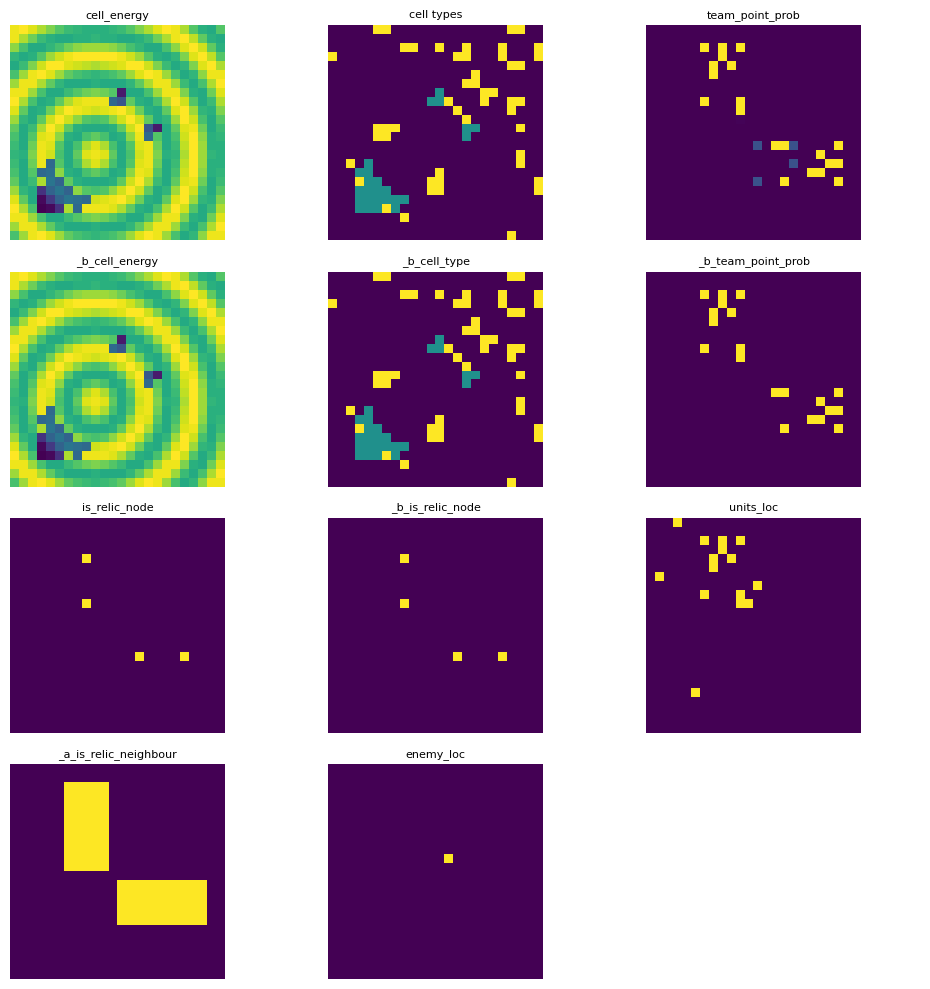

In [11]:
PLAYER_ID = 0
ob = obs[PLAYER_ID]
print(ob['game_step'][0][0][0] * 505, ob['match_step'][0][0][0] * 100)

units_loc = ob['units_loc_t0']
units_energy = ob['units_energy_t0']
enemy_loc = ob['enemy_loc_t0']

nu = env.mms[PLAYER_ID].past_obs[0]['units_mask'][0].sum()
print(f'number of units: {nu}')

plot_imgs([('cell_energy', ob['_a_cell_energy']), ('cell types', ob['_a_cell_type']), ('team_point_prob', ob['_a_team_point_prob']),
           ('_b_cell_energy', ob['_b_cell_energy']), ('_b_cell_type', ob['_b_cell_type']), ('_b_team_point_prob', ob['_b_team_point_prob']),    
            ('is_relic_node', ob['_a_is_relic_node']), ('_b_is_relic_node', ob['_b_is_relic_node']),  
           ('units_loc', units_loc > 0),  ('_a_is_relic_neighbour', ob['_a_is_relic_neighbour']), ('enemy_loc', enemy_loc > 0) 
           ])

# Enemey side

In [12]:
def get_player_init_pos(player_id):
  target_pos = (0, 0)
  if player_id == 1:
    target_pos = (23, 23)
  return target_pos


def on_enemy_side(cpos, player_id):
  target_pos = get_player_init_pos(player_id)
  mdist = manhatten_distance(target_pos, cpos)
  return mdist > MAP_WIDTH



on_enemy_side((20, 3), 0), on_enemy_side((20, 3), 1)

NameError: name 'manhatten_distance' is not defined

# Debug enery field

In [ ]:
sensor_mask = env.raw_obs['player_1']['sensor_mask']
map_energy = env.raw_obs['player_1']['map_features']['energy']
filtered_energy_field = map_energy[sensor_mask]
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 

axes[0].imshow(map_energy.T)
axes[1].imshow(sensor_mask.T)
filtered_energy_field

In [ ]:
m, f = env.mms[1].energy_node_estimator.is_energy_filed_match((1, 15), filtered_energy_field, sensor_mask)
f = np.asarray(f).copy()
f[~sensor_mask] = -1
plt.imshow(f.T)
m

In [ ]:
f[sensor_mask]

In [ ]:
m, f = env.mms[1].energy_node_estimator.is_energy_filed_match((4, 15), filtered_energy_field, sensor_mask)
f = np.asarray(f).copy()
f[~sensor_mask] = -1
plt.imshow(f.T)
m

In [ ]:
f[sensor_mask]

# Debug score assigment

In [ ]:
from ecobangbang.agent import *

In [ ]:
SUBMIT_AGENT = False

In [ ]:
self = a0

In [ ]:
mm = self.mm
is_explore_step = (mm.match_step <= 50 and mm.game_step < 303)

match_observed = mm.match_observed + anti_diag_sym(mm.match_observed)
energy_threshold = 60 + mm.match_step

# TODO: test drop it
if mm.match_step >= 70:
  energy_threshold = 60

has_found_relic = mm.has_found_relic_in_match()
n = (MAP_WIDTH * MAP_HEIGHT)
n_explore = n - match_observed.sum()
expore_score = n * EXPLORE_CELL_SCORE / (n_explore + 1)
print(
    f' +++ step={mm.game_step} to-exp-cell-num={n_explore} exp_score={expore_score} has_found_relic={has_found_relic}, last_match_found_relic={mm.last_match_found_relic}',
    file=sys.stderr)

def get_explore_weight(upos, energy, cpos):
  if mm.game_step >= (3 * MAX_MATCH_STEPS):
    return 0

  if not mm.last_match_found_relic:
    return 0

  if has_found_relic:
    return 0

  if match_observed[cpos[0]][cpos[1]]:
    return 0

  return min(expore_score, MAX_EXPLORE_SCORE)

energy_map = mm.cell_energy.copy()
energy_map[mm.cell_energy != CELL_UNKONWN] -= mm.unit_move_cost
energy_map[mm.cell_type == CELL_NEBULA] -= mm.nebula_energy_reduction
if not SUBMIT_AGENT:
  print(
      f'>>>>>>>>>>>>>>> nebula_energy_reduction={mm.nebula_energy_reduction}',
      file=sys.stderr)

fire_zone = self.gen_fire_zone()

player_init_pos = get_player_init_pos(mm.player_id)
d1 = generate_manhattan_dist(MAP_SHAPE2,
                             player_init_pos).astype(np.float32)
# d1[d1 > MAP_WIDTH] = MAP_WIDTH
d1 /= MAP_WIDTH

def get_fuel_energy(upos, energy, cpos):
  e = fuel = energy_map[cpos[0]][cpos[1]]
  fuel = right_tailed_exp(energy, fuel, energy_threshold)

  # Boost more net energy position without energy thresholding
  if e > 0 and fire_zone[cpos[0]][cpos[1]]:
    fuel += (e * d1[cpos[0]][cpos[1]])

  return fuel

enemy_sap_cost = self.get_enemy_sap_cost_map()
self.enemy_sap_cost = enemy_sap_cost

def get_open_relic_nb(upos, energy, cpos):
  """First visit on relic neighbour"""
  if not mm.is_relic_neighbour[cpos[0]][cpos[1]]:
    return 0

  # if not mm.match_visited[cpos[0]][cpos[1]]:
  # return RELIC_NB_SCORE

  p = mm.team_point_mass[cpos[0]][cpos[1]]
  if p < MIN_OPEN_RELIC_NB_PROB:
    return 0

  v = RELIC_NB_SCORE
  # Lower relic nb on enemy side
  if on_enemy_side(cpos, mm.player_id):
    # v = mm.unit_sap_cost / 10 * p
    v = mm.unit_sap_cost / 10

  # If enemy may sap it, lower its weight
  if enemy_sap_cost[cpos[0]][cpos[1]] > 0:
    v = mm.unit_sap_cost / 10 * 0.5

  last_visited_step = mm.last_visited_step[cpos[0]][cpos[1]]
  t = mm.game_step - last_visited_step
  alpha = np.log(t + 1) / LOG3
  w = min(alpha, 1) * v

  # cpos_nb_mask = gen_sap_range(cpos, self.mm.unit_sap_range)
  # if (mm.enemy_max_energy[cpos_nb_mask] > energy).sum() > 0:
  # w = -1
  return w

init_pos = get_player_init_pos(mm.enemy_id)
enemy_half = generate_manhattan_mask(MAP_SHAPE2,
                                     init_pos,
                                     range_limit=MAP_WIDTH - 1)
blind_shot_targets = ((~mm.visible) &
                      (mm.team_point_mass > IS_RELIC_CELL_PROB)
                      & enemy_half)
# blind_shot_targets = np.zeros(MAP_SHAPE2, dtype=bool)  # disable blind shot
self.blind_shot_targets = blind_shot_targets

def stay_on_relic(upos, energy, cpos):
  # If the relic node has been occupied by unit but not this one, lower its score
  if (mm.unit_positions[cpos[0]][cpos[1]] and not pos_equal(upos, cpos)):
    return 0

  # # Relic unit do not change relic position
  # p_unit = mm.team_point_mass[upos[0]][upos[1]]
  # if (p_unit > IS_RELIC_CELL_PROB and not pos_equal(upos, cpos)):
  # return 0

  # Will score only for relic p > 0.8
  v = RELIC_SCORE
  p = mm.team_point_mass[cpos[0]][cpos[1]]

  # Do not goto enemy side if energy below threshold
  if on_enemy_side(cpos, mm.player_id):
    v = mm.unit_sap_cost / 10

  # If enemy may sap it, lower its weight
  if not pos_equal(cpos, upos) and enemy_sap_cost[cpos[0]][cpos[1]] > 0:
    v = mm.unit_sap_cost / 10 * 0.5

  w = 0
  if p > IS_RELIC_CELL_PROB:
    w += v * p

  return w

hit_factor = 10
enemy_hit_map = self.get_sap_hit_map(hit_factor)
enemy_hit_map[
    blind_shot_targets] += mm.unit_sap_cost  # roughly adding 3 points
self.enemy_hit_map = enemy_hit_map

def get_sap_enemy_score(upos, energy, cpos):
  """Max sap damage that could be hit from the `cpos`."""
  if not can_attack(energy, mm):
    return 0

  # Do not attack from negtive energy position
  # fuel = energy_map[cpos[0]][cpos[1]]
  # if fuel <= 0:
  # return 0

  sap_range = gen_sap_range(cpos, self.mm.unit_sap_range)

  h = enemy_hit_map[sap_range].max()
  h /= hit_factor

  # Boost unit with extra energy for SAP
  h *= min(energy / BOOST_SAP_ENERGY_THRESHOOD, 1)

  # sap if energy is large (and unit not on relic)
  # if self.mm.team_point_mass[pos[0]][pos[1]] < 0.6:
  # h *= max((energy / energy_threshold), 1)
  return h

score_debug = {}

enemy_max_energy = maximum_filter(mm.enemy_max_energy, size=5)
self.enemy_max_energy = enemy_max_energy

def get_unit_cell_wt(upos, energy, cpos, unit_cost_map):
  if cant_move_to(upos, cpos, mm):
    return -9999

  if energy <= mm.enemy_max_energy[cpos[0]][cpos[1]]:
    return -9999

  # mdist = manhatten_distance(upos, cpos) + 7
  mdist = dd(manhatten_distance(upos, cpos) + 1)
  wt = 0.0001

  energy_ratio = energy / energy_threshold

  expore_wt = get_explore_weight(upos, energy, cpos)

  fuel_wt = get_fuel_energy(upos, energy, cpos)

  relic_nb_wt = get_open_relic_nb(upos, energy, cpos)

  on_relic_wt = stay_on_relic(upos, energy, cpos)

  sap_wt = get_sap_enemy_score(upos, energy, cpos)

  # If unit do not have much energy for one sap attack
  unit_on_relic = mm.team_point_mass[pos[0]][pos[1]] > IS_RELIC_CELL_PROB
  if (not (unit_on_relic and on_team_side(upos, mm.player_id))
      and self.enemy_sap_cost[cpos[0]][cpos[1]] >= energy):
    wt -= self.mm.unit_sap_cost / 10

  wt += (expore_wt + fuel_wt + relic_nb_wt + on_relic_wt + sap_wt) / mdist
  return wt

  score_debug[(tuple(upos), tuple(cpos))] = {
      'explore_wt': expore_wt,
      'fuel_wt': fuel_wt,
      'relic_nb_wt': relic_nb_wt,
      'on_relic_wt': on_relic_wt,
      'sap_wt': sap_wt,
      'energy_ratio': energy_ratio,
      'wt': wt,
      'mdist': mdist,
  }

  # if USE_RANDOM:
  # wt += np.random.rand() /et 1000
  return wt



In [ ]:
self.mm.game_step

In [ ]:
mm.get_unit_info(0, 10, t=0)

In [ ]:
upos = (21, 13)
unit_cost_map = self.compute_energy_cost_map(upos, asteriod_cost=75)

energy = 106
get_unit_cell_wt(upos, energy, upos, unit_cost_map)

In [ ]:
cpos = (20, 12)
get_unit_cell_wt(upos, energy, cpos, unit_cost_map)

In [ ]:
score_debug

In [ ]:
mm.team_point_mass[21][16]

In [ ]:
mm.game_step

In [ ]:
energy_lost_mask[]

In [ ]:
mm.sap_dropoff_factor_estimator.unit_energy_lost_step[21][16]

In [ ]:
from ecobangbang.agent import *

In [ ]:
hit_map = np.zeros((MAP_WIDTH, MAP_HEIGHT), dtype=float)

for i in range(MAX_UNIT_NUM):
  mask, pos, energy = self.mm.get_unit_info(self.mm.enemy_id, i, t=0)
  if not mask:
    continue

  if self.mm.enemy_positions[pos[0]][pos[1]]:
    p = self.mm.team_point_mass[pos[0]][pos[1]]
    hit_map[pos[0]][pos[1]] += (RELIC_SCORE * (p**2))

  for d in [1, 0]:
    x0 = max(0, (pos[0] - d))
    x1 = min(MAP_WIDTH, (pos[0] + d + 1))
    y0 = max(0, (pos[1] - d))
    y1 = min(MAP_HEIGHT, (pos[1] + d + 1))

    h = self.mm.unit_sap_cost
    if d == 1:
      h *= self.mm.unit_sap_dropoff_factor
    hit_map[x0:x1, y0:y1] += h

cpos = upos
sap_range = gen_sap_range(cpos, self.mm.unit_sap_range)

In [ ]:
plot_imgs([('enemy_hit_map', enemy_hit_map), ('mm.enemy_positions', mm.enemy_positions), ('hit_map', hit_map),
           ('sap_range', sap_range), ])

In [ ]:
print("============ game step 468 ========== \nunit[[9 3]] and cell ((1, 0)) wt={'explore_wt': 0, 'fuel_wt': -3.726653172078671e-05, 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': 0.0, 'energy_ratio': 2.25, 'wt': 8.81257345245768e-05, 'mdist': 3.138428376721003}\nunit[[9 3]] and cell ((2, 0)) wt={'explore_wt': 0, 'fuel_wt': -2.9813225376629368e-05, 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': 0.0, 'energy_ratio': 2.25, 'wt': 8.955064638162758e-05, 'mdist': 2.8531167061100025}\nunit[[9 3]] and cell ((3, 0)) wt={'explore_wt': 0, 'fuel_wt': -1.8633265860393355e-05, 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': 0.0, 'energy_ratio': 2.25, 'wt': 9.281606938736897e-05, 'mdist': 2.5937424601000023}\nunit[[9 3]] and cell ((4, 0)) wt={'explore_wt': 0, 'fuel_wt': -7.453306344157342e-06, 'relic_nb_wt': 0, 'on_relic_wt': 0, 'sap_wt': 0.0, 'energy_ratio': 2.25, 'wt': 9.683907053044235e-05, 'mdist': 2.357947691000002}\nunit[[9 3]] and cell ((5, 0)) wt={'explore_wt': 0, 'fuel_wt': 3.726653172078671e-06, 'relic_nb_wt': 0, 'on_relic_wt': ")

# Map Tile Shift Estimation

In [ ]:
partial = ob['_a_cell_type'][0, :, :]

In [ ]:
cell_map = ob['_b_cell_type'][0, :, :]
plt.imshow(cell_map.T)

In [ ]:
def shift_map(mp, n):
    mp = np.roll(mp, shift=-n, axis=0)  # Shift Up
    mp = np.roll(mp, shift=n, axis=1)  # Shift right
    return mp


fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

axes[0].imshow(partial.T)
axes[1].imshow(shift_map(partial, -1).T)

In [ ]:
a = cell_map == 2

a.size

In [ ]:
(cell_map[cell_map == 2] != partial[cell_map == 2]).any()

In [ ]:
x = np.array([-0.15, -0.1, -0.05, -0.025, 0.025, 0.05, 0.1, 0.15])

1 / x

<Axes: xlabel='x'>

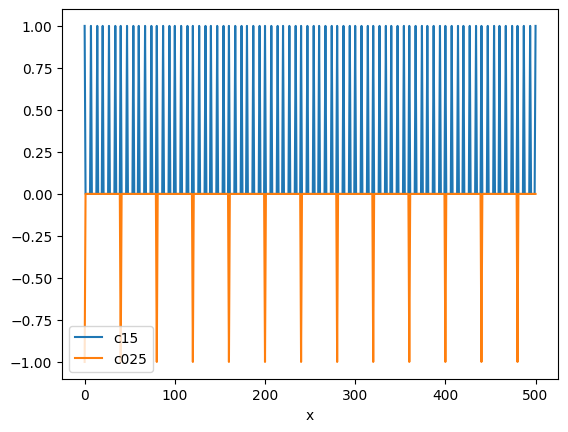

In [20]:
def should_tile_change(steps, nebula_tile_drift_speed):
    return (steps - 1) * abs(nebula_tile_drift_speed) % 1 > steps * abs(nebula_tile_drift_speed) % 1


x = np.linspace(0, 500, 501)


df = pd.DataFrame({
    'x': x,
    'c15': should_tile_change(x, 0.15).astype(int),
    # 'c20': -should_tile_change(x, 0.10).astype(int),
    # 'c05': should_tile_change(x, 0.05).astype(int),
    'c025': -should_tile_change(x, 0.025).astype(int),
})

df.set_index('x').plot()

In [21]:
len(should_tile_change(x, 0.025).astype(int))

501

In [23]:
np.argwhere(should_tile_change(x, 0.05).astype(int))

array([[  0],
       [ 20],
       [ 40],
       [ 60],
       [ 80],
       [100],
       [120],
       [140],
       [160],
       [180],
       [200],
       [220],
       [240],
       [260],
       [280],
       [300],
       [320],
       [340],
       [360],
       [380],
       [400],
       [420],
       [440],
       [460],
       [480],
       [500]])